In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import re
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
twitter_df=pd.read_csv("/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv")

In [4]:
twitter_df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [5]:
twitter_df.shape

(162980, 2)

In [6]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [7]:
twitter_df['category'].unique()

array([-1.,  0.,  1., nan])

In [8]:
twitter_df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [9]:
twitter_df = twitter_df.dropna()

In [10]:
twitter_df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [11]:
from nltk.corpus import stopwords
import nltk

# Ensure stopwords are downloaded
nltk.download('stopwords')

# Get stopwords list
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Processing The Text Data

In [13]:
def preprocess_text(clean_text):
    # check for NaN values
    if pd.isna(clean_text):
        return ""

    # convert text to lowercase
    clean_text = clean_text.lower()

    # remove emojies

    clean_text = clean_text.encode("ascii",'ignore').decode('ascii')

# remove special characters
    clean_text = re.sub(r'[^a-zA-Z0-9\s]',"",clean_text)

    # tokenize the text
    tokens = word_tokenize(clean_text)

    tokens = [word for word in tokens if word not in stop_words or word == 'not']
    return tokens

In [14]:
clean_text= twitter_df['clean_text'].apply(preprocess_text)
twitter_df['clean_text']=clean_text

# Distribution Of Sentiment Labels

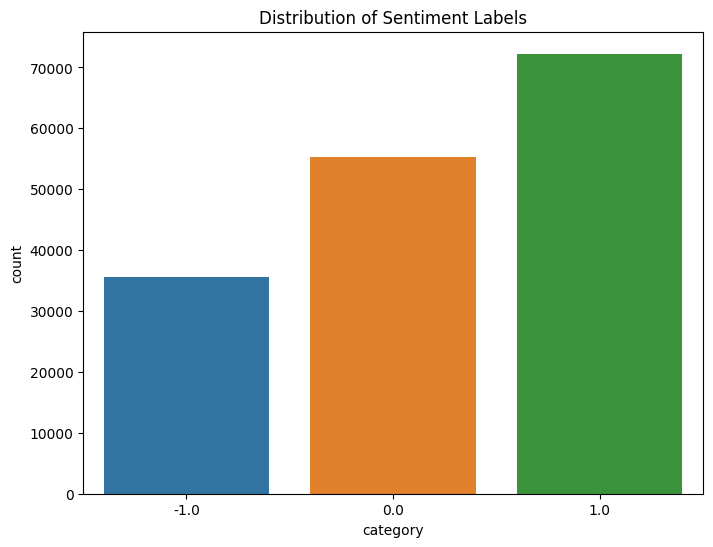

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(x='category',data=twitter_df)
plt.title("Distribution of Sentiment Labels")
plt.show()


# Analyzing word frequency

In [16]:
# tokenize and count word frequencies

all_tokens = [token for sublist in clean_text for token in sublist]
word_freq = Counter(all_tokens)


# Word Cloud Visualization

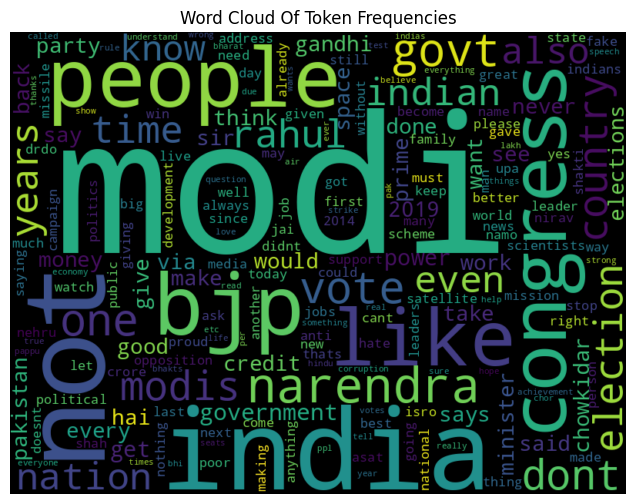

In [17]:
wordcloud = WordCloud(width = 800, height= 600, background_color='black').generate_from_frequencies(word_freq)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Word Cloud Of Token Frequencies")
plt.show()

**Sparse Matrix:** Stores only non-zero elements and their positions, saving memory when most values are zero.

**Dense Matrix:** Represents all values explicitly, including zeros, making it easier to work with but less memory-efficient for large datasets.

# Feature Engineering

In [46]:
text_data = clean_text.astype(str).tolist()  # Convert the text data into strings and store them as a list


# create TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # 'max_features=5000' limits the number of unique words to 5000 most important ones

# Fit the TF-IDF vectorizer to the text data and transform it into a sparse matrix
tfidf_features = tfidf_vectorizer.fit_transform(text_data)



# converting sparse matrix to dense array
tfidf_features_array = tfidf_features.toarray()


# Print the resulting TF-IDF features as a dense numerical array
print(tfidf_features_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Train-Test Split

In [47]:
X_train,X_test,Y_train,Y_test = train_test_split(tfidf_features_array,twitter_df['category'],test_size=0.2,random_state=0)

In [48]:
print("Training data shape: ")
print(X_train.shape)
print(Y_train.shape)

print("Test data shape:  ")
print(X_test.shape)
print(Y_test.shape)

Training data shape: 
(130375, 5000)
(130375,)
Test data shape:  
(32594, 5000)
(32594,)


# Training The Model

In [49]:
model = LogisticRegression()

model.fit(X_train,Y_train)

LogisticRegression()

# Model Evaluation

In [50]:
# Make predictions on the training data
y_pred_train = model.predict(X_train)


accuracy_train = accuracy_score(Y_train, y_pred_train)
print("Accuracy on training data:", accuracy_train)

# Make predictions on the test data
y_pred_test = model.predict(X_test)


accuracy_test = accuracy_score(Y_test, y_pred_test)
print("Accuracy on test data:", accuracy_test)

Accuracy on training data: 0.9039079578139981
Accuracy on test data: 0.8927103147818617


In [60]:
# Classification report for training data
y_pred_train = model.predict(X_train)  # Predictions on training data
print("Classification Report for Training Data:")
print(classification_report(Y_train, y_pred_train))

# Classification report for test data
y_pred_test = model.predict(X_test)  # Predictions on test data
print("Classification Report for Test Data:")
print(classification_report(Y_test, y_pred_test))


Classification Report for Training Data:
              precision    recall  f1-score   support

        -1.0       0.83      0.86      0.84     28477
         0.0       0.86      0.97      0.91     44196
         1.0       0.96      0.85      0.90     57702

    accuracy                           0.89    130375
   macro avg       0.88      0.89      0.89    130375
weighted avg       0.90      0.89      0.89    130375

Classification Report for Test Data:
              precision    recall  f1-score   support

        -1.0       0.80      0.84      0.82      7032
         0.0       0.86      0.97      0.91     11015
         1.0       0.95      0.83      0.89     14547

    accuracy                           0.88     32594
   macro avg       0.87      0.88      0.87     32594
weighted avg       0.89      0.88      0.88     32594



# Saving The Trained Model

In [64]:
joblib.dump(model,'/kaggle/working/twitter_sentiment_analysis_model.pkl')

['/kaggle/working/twitter_sentiment_analysis_model.pkl']

# Loading The Trained Model

In [66]:
def predict(input_text):


    input_data = np.array([input_text]).reshape(-1,1)

    input_data = tfidf_vectorizer.transform([input_text])

    prediction = model.predict(input_data)[0]

    if prediction == 1.0:
        print ("Positive")
    elif prediction == 0.0:
        print("Neutral")
    else:
        print("Negative")

    return prediction

In [67]:
input_text = "The weather forecast predicts rain in the evening. #WeatherUpdate"
print(f"Predicted Sentiment: {predict(input_text)}")

Neutral
Predicted Sentiment: 0.0


In [68]:
input_text = "Missed my train again because of these never-ending delays. Feeling Sad and Angry! #CommuteProblems"
print(f"Predicted Sentiment: {predict(input_text)}")

Negative
Predicted Sentiment: -1.0


In [69]:
input_text = "Just got promoted at work! Hard work really pays off. Feeling so grateful and motivated! #CareerGoals"
print(f"Predicted Sentiment: {predict(input_text)}")

Negative
Predicted Sentiment: -1.0


# Tried to Fine Tune the model by undersampling...(Extra)

In [54]:
from imblearn.under_sampling import RandomUnderSampler

In [55]:
from collections import Counter
print("Original Training Class Distribution:", Counter(Y_train))

# Apply undersampling
undersampler = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_resampled, Y_resampled = undersampler.fit_resample(X_train, Y_train)

# Check new class distribution
print("Resampled Training Class Distribution:", Counter(Y_resampled))

# Train Logistic Regression with class weights
model = LogisticRegression(random_state=42)
model.fit(X_resampled, Y_resampled)

# Predictions on training data
y_pred_train = model.predict(X_train)
print("Classification Report for Training Data:")
print(classification_report(Y_train, y_pred_train))
print("Accuracy on Training Data:", accuracy_score(Y_train, y_pred_train))

# Predictions on test data
y_pred_test = model.predict(X_test)
print("Classification Report for Test Data:")
print(classification_report(Y_test, y_pred_test))
print("Accuracy on Test Data:", accuracy_score(Y_test, y_pred_test))

Original Training Class Distribution: Counter({1.0: 57702, 0.0: 44196, -1.0: 28477})
Resampled Training Class Distribution: Counter({-1.0: 28477, 0.0: 28477, 1.0: 28477})
Classification Report for Training Data:
              precision    recall  f1-score   support

        -1.0       0.83      0.86      0.84     28477
         0.0       0.86      0.97      0.91     44196
         1.0       0.96      0.85      0.90     57702

    accuracy                           0.89    130375
   macro avg       0.88      0.89      0.89    130375
weighted avg       0.90      0.89      0.89    130375

Accuracy on Training Data: 0.8923183125599233
Classification Report for Test Data:
              precision    recall  f1-score   support

        -1.0       0.80      0.84      0.82      7032
         0.0       0.86      0.97      0.91     11015
         1.0       0.95      0.83      0.89     14547

    accuracy                           0.88     32594
   macro avg       0.87      0.88      0.87     3259

In [56]:
def predict(input_text):


    input_data = np.array([input_text]).reshape(-1,1)

    input_data = tfidf_vectorizer.transform([input_text])

    prediction = model.predict(input_data)[0]

    if prediction == 1.0:
        print ("Positive")
    elif prediction == 0.0:
        print("Neutral")
    else:
        print("Negative")

    return prediction

In [58]:
input_text=input("Enter the tweet")
print(f"Predicted Sentiment: {predict(input_text)}")

Enter the tweet frustratation


Neutral
Predicted Sentiment: 0.0


# THE END 